## System Description
1. We have a set of COFs from a database. Each COF is characterized by a feature vector $$x_{COF} \in X \subset R^d$$ were d=14.


2. We have **two different types** of simulations to calculate **the same material property $S_{Xe/Kr}$**. Therefore, we have a Single-Task/Objective (find the material with the optimal selevtivity), Multi-Fidelity problem. 
    1. low-fidelity  = Henry coefficient calculation - MC integration - cost=1
    2. high-fidelity = GCMC mixture simulation - 80:20 (Kr:Xe) at 298 K and 1.0 bar - cost=30


3. We will initialize the system with *two* COFs at both fidelities in order to initialize the Covariance Matrix.
    - The fist COF will be the one closest to the center of the normalized feature space
    - The second COF will be chosen at random


4. Each surrogate model will **only train on data acquired at its level of fidelity** (Heterotopic data). $$X_{lf} \neq X_{hf} \subset X$$
    1. We could use the augmented EI acquisition function from [here](https://link.springer.com/content/pdf/10.1007/s00158-005-0587-0.pdf)
    2. We could use a naive implementation of the [misoKG](https://papers.nips.cc/paper/2017/file/df1f1d20ee86704251795841e6a9405a-Paper.pdf) acquisition function
    3. **OR** we could use the acquisition function from the [tutorial](https://botorch.org/tutorials/discrete_multi_fidelity_bo)


5. **kernel model**: 
    1.  We need a Gaussian Process (GP) that will give a *correlated output for each fidelity* i.e. we need a vector-valued kernel
    2. Given the *cost aware* acquisition function, we anticipate the number of training points at each fidelity *will not* be equal (asymmetric scenario) $$n_{lf} > n_{hf}$$
        - perhaps we can force the symmetric case, $n_{lf} = n_{hf} = n$, if we can include `missing` or `empty` entries in the training sets.

In [1]:
import torch
import gpytorch
from botorch.models import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from scipy.stats import norm
import math 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [2]:
###
#  Load Data
###
f = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(f["X"][:]))
# simulation data
y = [torch.from_numpy(np.transpose(f["henry_y"][:])), 
     torch.from_numpy(np.transpose(f["gcmc_y"][:]))]
# associated simulation costs
cost = [torch.from_numpy(np.transpose(f["henry_total_elapsed_time"][:])), 
        torch.from_numpy(np.transpose(f["gcmc_elapsed_time"][:]))]

print("raw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)
    
    
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)

raw data - 
	X: torch.Size([608, 14])
	fidelity: 0
		y: torch.Size([608])
		cost:  torch.Size([608])
	fidelity: 1
		y: torch.Size([608])
		cost:  torch.Size([608])

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


## Helper Functions

#### Construct Initial Inputs

In [3]:
# find COF closest to the center of feature space
def get_initializing_COF(X):
    # center of feature space
    feature_center = np.ones(X.shape[1]) * 0.5
    # max possible distance between normalized features
    min_dist = np.inf
    min_id = 0 # dummy id 
    for i in range(nb_COFs):
        dist = sum((X[i] - feature_center) * (X[i] - feature_center)).item()
        if dist < min_dist:
            min_dist = dist
            min_id = i
    return min_id

In [4]:
# construct feature matrix of acquired points
def build_X_train(ids_acquired, fidelity_acquired):
    return torch.cat((X[ids_acquired, :], fidelity_acquired), dim=1)

# construct output vector for acquired points
def build_y_train(ids_acquired, fidelity_acquired):
    train_y = torch.tensor((), dtype=torch.float64).new_zeros((ids_acquired.shape[0], 1))
    for i, fid in enumerate(fidelity_acquired):
        train_y[i][0] = y[fid][ids_acquired[i]]
    return train_y

# construct vector to track accumulated cost of acquired points
def build_cost(ids_acquired, fidelity_acquired):
    costs_acquired = torch.tensor((), dtype=torch.float64).new_zeros((ids_acquired.shape[0], 1))
    for i, fid in enumerate(fidelity_acquired):
        costs_acquired[i][0] = cost[fid][ids_acquired[i]]
    return costs_acquired

#### Surrogate Model

In [5]:
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=X_train.shape[1] - 1
    )   
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return mll, model

#### Acquisition Function

In [6]:
# calculate posterior mean and variance
def mu_sigma(model, X, fidelity):
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), f_posterior.variance.squeeze().detach().numpy()

# get the current "effective best solution" 
def get_y_max(ids_acquired, fidelity_acquired, desired_fidelity):
    y_max = torch.tensor((), dtype=torch.float64).new_zeros(1)
    for i, fid in enumerate(fidelity_acquired):
        if (fid == desired_fidelity) & (y[fid][ids_acquired[i]] > y_max):
            y_max = y[fid][ids_acquired[i]]
    return y_max.item()

In [7]:
def multi_fidelity_correlation(model, X, fidelity, ids_acquired, fidelity_acquired):
    # get covariance matrix of acquired data points
    K = model.covar_module(X_train).evaluate() 
    K_inv = torch.inverse(K) # take the inverse

    # get posterior for fidelity f
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    sigma_f = torch.flatten(model.posterior(X_f).variance)

    # get posterior for high-fidelity
    hf = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) 
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity
    sigma_hf = torch.flatten(model.posterior(X_hf).variance)

    # Compute the covariance between X_hf and X_f, using covariance kernel
    sigma_prior = model.covar_module.forward(X_hf, X_f, diag=True) # want diag

    # Compute the covariance between X_f and X_train 
    # rows are [k(x,s), (x_1, s_1), ..., k((x, s), (x_N, s_N))]
    cov_f_and_data = model.covar_module.forward(X_f, X_train).evaluate()

    # Compute the covariance between X_hf and X_train
    # rows are [k(x,s'), (x_1, s_1), ..., k((x, s'), (x_N, s_N))]
    cov_hf_and_data = model.covar_module.forward(X_hf, X_train).evaluate()

    # perform matrix multiplication
    sigma_reduction = torch.matmul(torch.matmul(cov_f_and_data, K_inv), 
                       torch.t(cov_hf_and_data)).diag()
    # calculate covariance
    posterior_cov = sigma_prior - sigma_reduction
    # calculate the correlation
    corr = posterior_cov / (torch.sqrt(sigma_f) * torch.sqrt(sigma_hf))
    return corr

In [8]:
# calculate the cost ratio
def cost_ratio(fidelity, fidelity_acquired, costs_acquired):
    avg_cost_f  = torch.mean(costs_acquired[fidelity_acquired == fidelity]).item()
    avg_cost_hf = torch.mean(costs_acquired[fidelity_acquired == 1]).item()
    return avg_cost_hf / avg_cost_f

In [9]:
# Expected Imrovement function, only use hf
def EI_hf(model, X, ids_acquired, fidelity_acquired):
    hf_mu, hf_sigma = mu_sigma(model, X, 1)
    y_max = get_y_max(ids_acquired, fidelity_acquired, 1)
    
    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(nb_COFs))

In [10]:
# 1. We're going to get a sorted list of propoed acquisition values at each fidelity 
# 2. Then, we will determine which value is highest and from which fidelity it was derived
# 3. Add that data point and associated fidelity to the training data
# 4. Retrian model and repreat process
def acquisition(model, X, fidelity, ids_acquired, fidelity_acquired, costs_acquired):
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, ids_acquired, fidelity_acquired) 
    
    # augmenting functions
    a1 = multi_fidelity_correlation(model, X, fidelity, ids_acquired, fidelity_acquired)
    a2 = 1.0 # no systematic random error noise 
    a3 = cost_ratio(fidelity, fidelity_acquired, costs_acquired)

    acquisition_values = torch.from_numpy(ei) * a1 * a2 * a3
    
    return acquisition_values, acquisition_values.argsort(descending=True) # sort in descending order

## Run MFBO

In [11]:
###
#  construct initial inputs
###
nb_COFs = X.shape[0] # total number of COFs data points 
nb_iterations = 75  # BO budget

ids_acquired = torch.ones(1, dtype=int) * get_initializing_COF(X)
fidelity_acquired = torch.ones((1, 1), dtype=int) # start with high-fidelity
costs_acquired = build_cost(ids_acquired, fidelity_acquired)

X_train = build_X_train(ids_acquired, fidelity_acquired)
y_train = build_y_train(ids_acquired, fidelity_acquired)

print("Initialization - \n")
print("\tid acquired = ", ids_acquired.item())
print("\tfidelity acquired = ", fidelity_acquired.item())
print("\tcosts acquired = ", costs_acquired.item(), " [min]")

print("\tTraining data:\n")
print("\t\t X train shape = ", X_train.shape)
print("\t\t y train shape = ", y_train.shape)
print("\t\t training feature vector = \n", X_train[0])

Initialization - 

	id acquired =  25
	fidelity acquired =  1
	costs acquired =  399.7576660990715  [min]
	Training data:

		 X train shape =  torch.Size([1, 15])
		 y train shape =  torch.Size([1, 1])
		 training feature vector = 
 tensor([0.1500, 0.4533, 0.1088, 0.5523, 0.4387, 0.1463, 0.3480, 0.2643, 0.0000,
        0.1769, 0.2237, 0.0000, 0.0000, 0.3471, 1.0000], dtype=torch.float64)


In [12]:
track_acq_vals = True
if track_acq_vals:
    stored_acquisition_values = torch.zeros(nb_iterations, dtype=float)


###
#  Evaluate acquisition function at each fidelity
###
for i in range(1, nb_iterations):
    mll, model = train_surrogate_model(X_train, y_train)
    
    ###
    #  Acquisition Function
    ###
    lf_acquisition_values, lf_acquisition_sorted = acquisition(model, X, 0, ids_acquired, 
                                                               fidelity_acquired, costs_acquired)
    hf_acquisition_values, hf_acquisition_sorted = acquisition(model, X, 1, ids_acquired, 
                                                               fidelity_acquired, costs_acquired)
    
    if 0 not in fidelity_acquired: # if no low-fidelity points, force the choice
        for id_ in lf_acquisition_sorted:
            if not id_.item() in ids_acquired:
                lf_id_max_aquisition = id_.item()
                break
        ids_acquired = torch.cat((ids_acquired, torch.ones(1, dtype=int) * lf_id_max_aquisition))
        fidelity_acquired = torch.cat((fidelity_acquired, torch.zeros((1, 1), dtype=int)))
        acquisition_value = lf_acquisition_values[lf_id_max_aquisition]
    else:
        for id_ in lf_acquisition_sorted:
            if not id_ in ids_acquired:
                lf_id_max_aquisition = id_.item()
                break
        for id_ in hf_acquisition_sorted:
            if not id_ in ids_acquired:
                hf_id_max_aquisition = id_.item()
                break
        if lf_acquisition_values[lf_id_max_aquisition] >= hf_acquisition_values[hf_id_max_aquisition]:
            ids_acquired = torch.cat((ids_acquired, torch.ones(1, dtype=int) * lf_id_max_aquisition))
            fidelity_acquired = torch.cat((fidelity_acquired, torch.zeros((1, 1), dtype=int)))
            acquisition_value = lf_acquisition_values[lf_id_max_aquisition]
        else:
            ids_acquired = torch.cat((ids_acquired, torch.ones(1, dtype=int) * hf_id_max_aquisition))
            fidelity_acquired = torch.cat((fidelity_acquired, torch.ones((1, 1), dtype=int)))
            acquisition_value = hf_acquisition_values[hf_id_max_aquisition]
    
    # update training sets and cost
    X_train = build_X_train(ids_acquired, fidelity_acquired)
    y_train = build_y_train(ids_acquired, fidelity_acquired)
    costs_acquired = build_cost(ids_acquired, fidelity_acquired)
    
    # track acquisition value
    if track_acq_vals:
        stored_acquisition_values[i] = acquisition_value

In [13]:
# ids_acquired
# fidelity_acquired
# costs_acquired
# stored_acquisition_values

## PLOTS

In [14]:
index = np.zeros(len(ids_acquired), dtype=int)
max_selectivity  = np.zeros(len(ids_acquired), dtype=float)
net_cost  = np.zeros(len(ids_acquired), dtype=float)

nb_COFs_initialization = 1
fid_color = []

for i in range(len(ids_acquired)):
    ittration = i + nb_COFs_initialization
    index[i] = ittration
    net_cost[i] = sum(costs_acquired[:i])
    if fidelity_acquired[i] == 1:
        max_selectivity[i]  = max(y[1][ids_acquired[:ittration]])
        fid_color.append("tab:red")
    else:
        max_selectivity[i]  = max(y[0][ids_acquired[:ittration]])
        fid_color.append("tab:cyan")


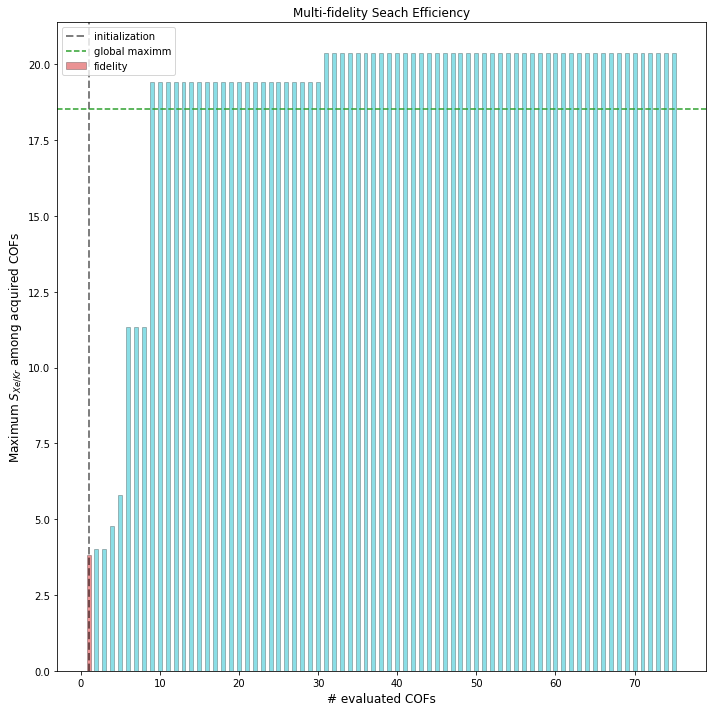

In [15]:
plt.figure(figsize=(10, 10))

plt.axvline(x=nb_COFs_initialization, label="initialization", color="k", alpha=0.5, linestyle="--", lw=2)
plt.axhline(y=max(y[1]), label="global maximm", color="tab:green", ls="--", lw=1.5)

plt.bar(index, max_selectivity, 0.5, label="fidelity", align="center", 
        color=fid_color, alpha=0.5, edgecolor="k", lw=0.5)

plt.title("Multi-fidelity Seach Efficiency")
plt.xlabel("# evaluated COFs", fontsize=12)
plt.ylabel("Maximum " + "$S_{Xe/Kr}$" + " among acquired COFs", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.png", dpi=600, format="png")
# plt.savefig("figs/mfbo/multi_fidelity_bo_search_efficientcy_curve.pdf", dpi=600, format="pdf")
plt.show()

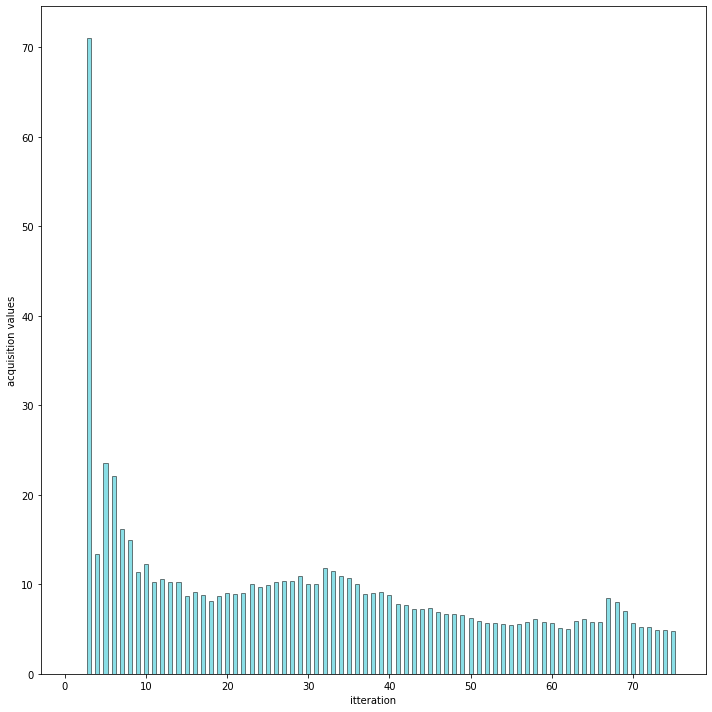

In [16]:
plt.figure(figsize=(10, 10))
plt.bar(index, stored_acquisition_values.detach().numpy(), width=0.5, align="center", color=fid_color, 
        alpha=0.5, edgecolor="k", lw=1.0)
plt.xlabel("itteration")
plt.ylabel("acquisition values")

plt.tight_layout()
plt.savefig("figs/mfbo/multi_fidelity_bo_acquisition_values.png", dpi=600, format="png")
# plt.savefig("figs/mfbo/multi_fidelity_bo_acquisition_values.pdf", dpi=600, format="pdf")
plt.show()

/home/ng/.local/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/ng/.local/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


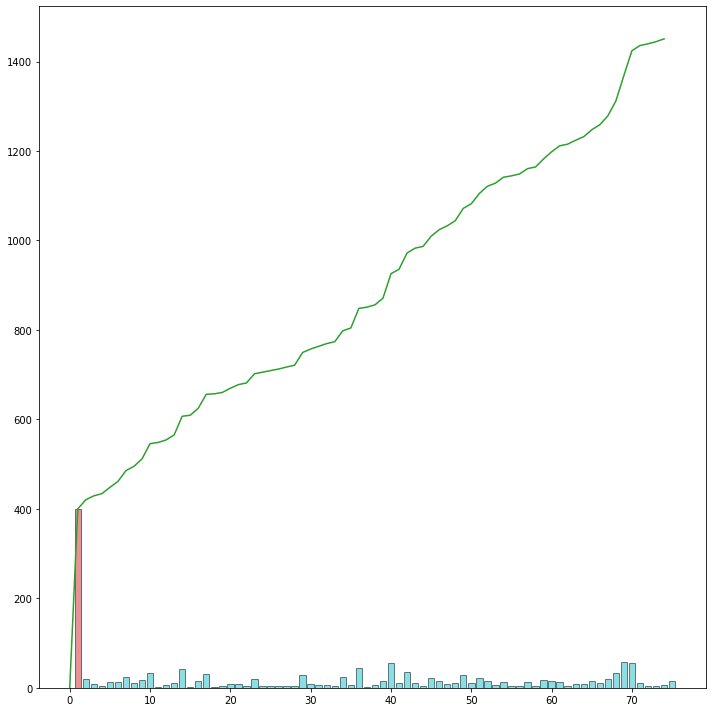

In [17]:
plt.figure(figsize=(10, 10))

plt.bar(index, costs_acquired, color=fid_color, alpha=0.5, edgecolor="k", lw=1.0)

plt.plot(index - 1, net_cost, color="tab:green")

plt.tight_layout()
plt.savefig("figs/mfbo/multi_fidelity_bo_cost_values.png", dpi=600, format="png")
# plt.savefig("figs/mfbo/multi_fidelity_bo_cost_values.pdf", dpi=600, format="pdf")
plt.show()